# Diffusion example

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import PIL.ImageOps
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import convolve

## Helper code

In [2]:
def print_info(arr):
    print(f"Got array of shape {arr.shape} {arr.dtype} bounds {np.min(arr)} {np.max(arr)}")


def load_image_as_numpy_array(input_file):
    img = Image.open(input_file)
    arr = np.array(img).astype(np.float32)
    print_info(arr)
    return arr


def show_image(img):
    img = np.round(img).astype(int)
    plt.imshow(img)


def add_colorbar(fig, fig_imshow, ax):
    """Add colorbar to a given figure"""
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(fig_imshow, cax=cax)

## Load image

Got array of shape (669, 819, 3) float32 bounds 0.0 250.0


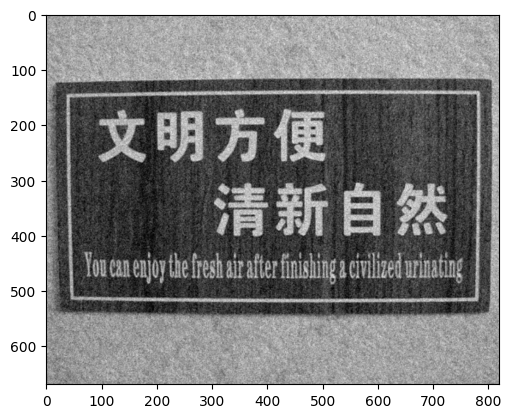

In [3]:
input_file = "diffusion.png"
in_arr = load_image_as_numpy_array(input_file)
arr = np.copy(in_arr)

show_image(arr)

## Homogeneous diffusion

Running homogeneous diffusion with hyperparameters tau=0.1 h=1 n_steps=10


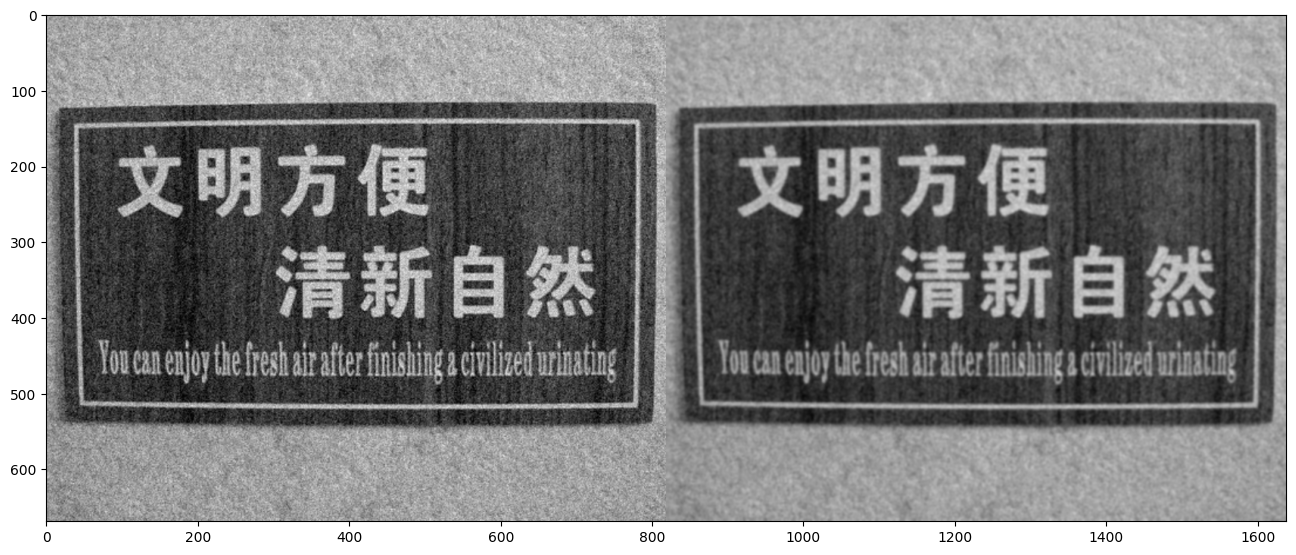

In [4]:
def apply_homogeneous_diffusion_step(input_image, tau, h):
    # START TODO #################
    # apply the explicit finite difference scheme
    kernel = np.array([
        [0, tau / (h ** 2), 0],
        [tau / (h ** 2), 1 - (4 * tau) / (h ** 2), tau / (h ** 2)],
        [0, tau / (h ** 2), 0]
    ])
    new_image = convolve(input_image, kernel[:, :, np.newaxis], mode='mirror')
    # END TODO ###################
    return new_image


tau, h, n_steps = 0.1, 1, 10
print(f"Running homogeneous diffusion with hyperparameters " f"tau={tau} h={h} n_steps={n_steps}")
arr_hg = np.copy(in_arr)
for n in range(10):
    arr_hg = apply_homogeneous_diffusion_step(arr_hg, 0.1, 1)

plt.figure(figsize=(16, 8))
both = np.concatenate((in_arr, arr_hg), axis=1)
show_image(both)

## Nonlinear diffusion

I decided to use another **explicit scheme** that is defined at the edges of the pixels, using the equations from the slides, the discretized divergence equation:
$$
\operatorname{div} \left( g(|\nabla u|^2) \nabla u \right)_{i,j} \approx g_{i+\frac{1}{2},j} \partial_x u_{i+\frac{1}{2},j} - g_{i-\frac{1}{2},j} \partial_x u_{i-\frac{1}{2},j} + g_{i,j+\frac{1}{2}} \partial_y u_{i,j+\frac{1}{2}} - g_{i,j-\frac{1}{2}} \partial_y u_{i,j-\frac{1}{2}}
$$
and the discretized time derivative:
$$
\partial_t u_{i,j} \approx \frac{u_{i,j}^{k+1} - u_{i,j}^k}{\tau}
$$
Then using: 
$$
\operatorname{div} \left( g(|\nabla u|^2) \nabla u \right)_{i,j} = \partial_t u_{i,j}
$$
we get:
$$
\frac{u_{i,j}^{k+1} - u_{i,j}^k}{\tau} = g_{i+\frac{1}{2},j} \partial_x u_{i+\frac{1}{2},j} - g_{i-\frac{1}{2},j} \partial_x u_{i-\frac{1}{2},j} + g_{i,j+\frac{1}{2}} \partial_y u_{i,j+\frac{1}{2}} - g_{i,j-\frac{1}{2}} \partial_y u_{i,j-\frac{1}{2}}
$$
Rearranging this to solve for $u_{i,j}^{k+1}$, we get an update rule:
$$
u_{i,j}^{k+1} = u_{i,j}^k + \tau \left( g_{i+\frac{1}{2},j} \partial_x u_{i+\frac{1}{2},j} - g_{i-\frac{1}{2},j} \partial_x u_{i-\frac{1}{2},j} + g_{i,j+\frac{1}{2}} \partial_y u_{i,j+\frac{1}{2}} - g_{i,j-\frac{1}{2}} \partial_y u_{i,j-\frac{1}{2}} \right)
$$

I decided to use this scheme as it seemed easier to implement using kernel convolution.

Diffusivity:
Got array of shape (669, 819, 3) float32 bounds 3.987436258670811e-37 1.0


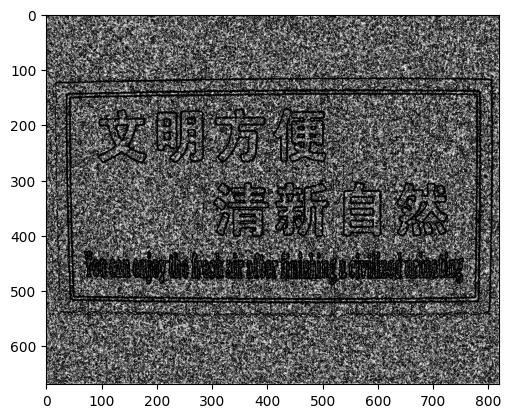

Difference in current step:
Got array of shape (669, 819, 3) float32 bounds 0.0 8.161720275878906


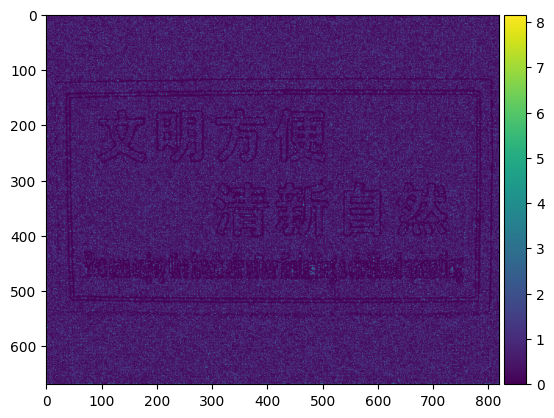

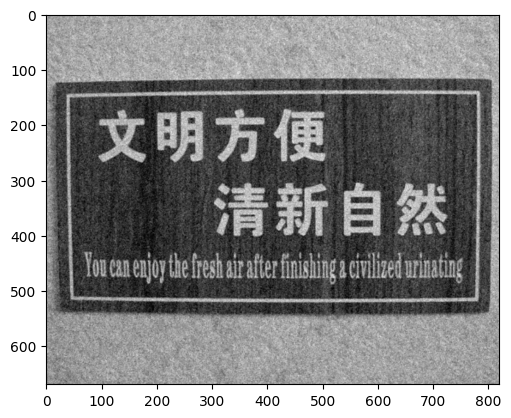

In [5]:
def apply_nonlinear_diffusion_step(input_image, tau, lambd, debug=False):
    # START TODO #################
    # apply nonlinear isotropic diffusion with gaussian diffusivity
    # 1. compute diffusivity
    kernel = np.array([
        [0, -1/2, 0],
        [0,    0, 0],
        [0,  1/2, 0]
    ])
    dyu = convolve(input_image, kernel[:, :, np.newaxis], mode='mirror')
    dxu = convolve(input_image, kernel.T[:, :, np.newaxis], mode='mirror')
    
    diffu = np.exp(-(dyu ** 2 + dxu ** 2) / (lambd ** 2))
    # END TODO ###################

    if debug:
        print(f"Diffusivity:")
        print_info(diffu)
        plt.imshow(diffu)
        plt.show()

    # 2. compute diffusivities between pixels
    kernel = np.array([
        [0,   0, 0],
        [0, 1/2, 0],
        [0, 1/2, 0]
    ])
    
    diffu_y_half = convolve(diffu, kernel[:, :, np.newaxis], mode='mirror')
    diffu_x_half = convolve(diffu, kernel.T[:, :, np.newaxis], mode='mirror')

    # START TODO #################
    # 3. implement the explicit scheme
    kernel = np.array([
        [0,  0, 0],
        [0, -1, 0],
        [0,  1, 0]
    ])
    
    dyu_half = convolve(input_image, kernel[:, :, np.newaxis], mode='mirror')
    dxu_half = convolve(input_image, kernel.T[:, :, np.newaxis], mode='mirror')
    
    kernel = np.array([
        [0, -1, 0],
        [0,  1, 0],
        [0,  0, 0]
    ])
    
    divergence = convolve(np.multiply(diffu_y_half, dyu_half), kernel[:, :, np.newaxis], mode='mirror') \
            + convolve(np.multiply(diffu_x_half, dxu_half), kernel.T[:, :, np.newaxis], mode='mirror')

    new_image = input_image + tau * divergence
    # END TODO ###################

    if debug:
        print(f"Difference in current step:")
        delta = np.abs(input_image - new_image)
        print_info(delta)
        fig, ax = plt.subplots()
        fig_imshow = plt.imshow(delta.mean(-1))
        add_colorbar(fig, fig_imshow, ax)
        plt.show()

        fig, ax = plt.subplots()
        show_image(new_image)
        plt.show()

    return new_image


arr = np.copy(in_arr)
out_arr = apply_nonlinear_diffusion_step(arr, 0.1, 10, debug=True)

Running nonlinear diffusion with hyperparameters tau=0.1 lambda=10 n_steps=100


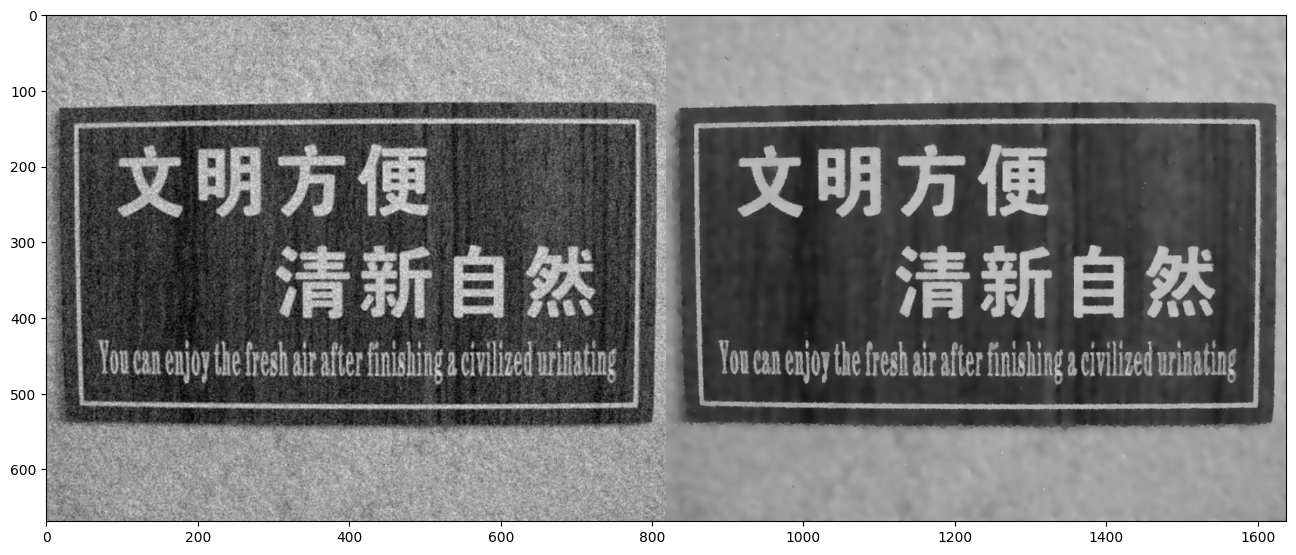

In [6]:
def apply_nonlinear_diffusion(in_arr, tau, lambd, n_steps):
    print(
        f"Running nonlinear diffusion with hyperparameters "
        f"tau={tau} lambda={lambd} n_steps={n_steps}"
    )
    arr_nid = np.copy(in_arr)
    for n in range(n_steps):
        arr_nid = apply_nonlinear_diffusion_step(arr_nid, tau, lambd)
    plt.figure(figsize=(16, 8))
    both = np.concatenate((in_arr, arr_nid), axis=1)
    show_image(both)
    plt.show()


tau = 0.1
lambd = 10
T = 10
n_steps = np.ceil(T / tau).astype(int)

apply_nonlinear_diffusion(in_arr, tau, lambd, n_steps)